In [1]:
import sys
import os
import pandas as pd
import numpy as np
import configparser
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import lightgbm as lgb
import lightgbm as lgb
from plotnine import ggplot, aes, geom_boxplot, labs, scale_color_manual, geom_point


project_root = "/home/dan1dr/zrive-ds-4q24-churn"

# Define the project root path
current_wd = os.getcwd()

# Change the working directory if necessary
if current_wd != project_root:
    print(f"Changing working directory from {current_wd} to {project_root}")
    os.chdir(project_root)
else:
    print("Already in the correct path")

# Add 'src' directory to sys.path
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    print(f"Adding {src_path} to sys.path")
    sys.path.insert(0, src_path)

# Import the modules
from db_connectors.bigquery_service import BigqueryService
from data_gathering import data_gathering
from utils.logger import get_logger
from data_cleaning import data_cleaning
from feature_computation import feature_computation
from evaluation import evaluation

config = configparser.ConfigParser()
config.read("src/params.ini")

logger = get_logger(__name__)

Changing working directory from /home/dan1dr/zrive-ds-4q24-churn/src/eda to /home/dan1dr/zrive-ds-4q24-churn
Adding /home/dan1dr/zrive-ds-4q24-churn/src to sys.path


In [2]:
import configparser
from data_gathering import data_gathering
from data_cleaning import data_cleaning
from feature_computation import feature_computation
from modeling import modeling
from evaluation import evaluation
from utils.logger import get_logger


# Instantiate logger
logger = get_logger(__name__)


def get_initial_params():
    """
    Loads all relevant parameters into a global variable. These parameters are then accessible to other functions in the script.
    Each function can consume the parameters it requires for its operation.
    This approach ensures centralized management and consistency of parameters across different functions.

    Returns:
        None: This function does not return a value but populates a global variable
        with necessary parameters.
    """
    global train_from, train_to, end_date, logistic_regression_params, lightgbm_params

    config = configparser.ConfigParser()
    config.read("src/params.ini")

    train_from = config.get("PARAMS", "train_from")
    train_to = config.get("PARAMS", "train_to")
    end_date = config.get("PARAMS", "end_date")
    # Load Logistic Regression parameters
    logistic_regression_params = {
        "penalty": config.get("LOGISTIC_REGRESSION", "penalty", fallback="l2"),
        "C": config.getfloat("LOGISTIC_REGRESSION", "C", fallback=1.0),
        "solver": config.get("LOGISTIC_REGRESSION", "solver", fallback="saga"),
        "max_iter": config.getint("LOGISTIC_REGRESSION", "max_iter", fallback=10000),
    }

    # Load LightGBM parameters
    lightgbm_params = {
        "boosting_type": config.get("LIGHTGBM", "boosting_type", fallback="gbdt"),
        "num_leaves": config.getint("LIGHTGBM", "num_leaves", fallback=12),
        "max_depth": config.getint("LIGHTGBM", "max_depth", fallback=-1),
        "learning_rate": config.getfloat("LIGHTGBM", "learning_rate", fallback=0.005),
        "n_estimators": config.getint("LIGHTGBM", "n_estimators", fallback=100),
        "random_state": config.getint("LIGHTGBM", "random_state", fallback=500),
        "colsample_bytree": config.getfloat(
            "LIGHTGBM", "colsample_bytree", fallback=0.64
        ),
        "subsample": config.getfloat("LIGHTGBM", "subsample", fallback=0.7),
        "reg_alpha": config.getint("LIGHTGBM", "reg_alpha", fallback=0),
        "reg_lambda": config.getint("LIGHTGBM", "reg_lambda", fallback=1),
    }

In [6]:
query = """
WITH selectable_customer AS (
        SELECT customer_id
        FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
        GROUP BY customer_id
    ), 

    customer_selected AS (
        SELECT customer_id AS selected_customer
        FROM   selectable_customer
        WHERE  RAND() < 0.1
    )

    SELECT *
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
    INNER JOIN customer_selected
    ON customer_id = selected_customer
    WHERE IS_CUST_SEGM_RESI > 0
    AND IS_CUST_BILL_POST_CURR = TRUE
    AND CUST_BUNDLE_CURR = 'FMC'
    AND NUM_IMPAGOS = 0
    AND pago_final_0 IS NOT NULL
"""

In [94]:
query = """
WITH selectable_customer AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
    GROUP BY customer_id
), 

customer_selected AS (
    SELECT customer_id AS selected_customer
    FROM   selectable_customer
    WHERE  RAND() < 0.1
)

SELECT *
FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
INNER JOIN customer_selected
ON customer_id = selected_customer
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""

query = """
WITH selectable_customer AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
    GROUP BY customer_id
), 

customer_selected AS (
    SELECT customer_id AS selected_customer
    FROM   selectable_customer
    WHERE  RAND() < 0.01
)

SELECT *
FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
INNER JOIN customer_selected
ON customer_id = selected_customer
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""

In [36]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data, train_from, train_to, logger
)

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 286004
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping column NUM_FIX_PORT_LAST_6_MONTHS
INFO - Sh

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 286369
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping column NUM_FIX_PORT_LAST_6_MONTHS
INFO - Sh

[LightGBM] [Info] Number of positive: 398, number of negative: 14030
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66272
[LightGBM] [Info] Number of data points in the train set: 14428, number of used features: 346
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.027585 -> initscore=-3.562501
[LightGBM] [Info] Start training from score -3.562501


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


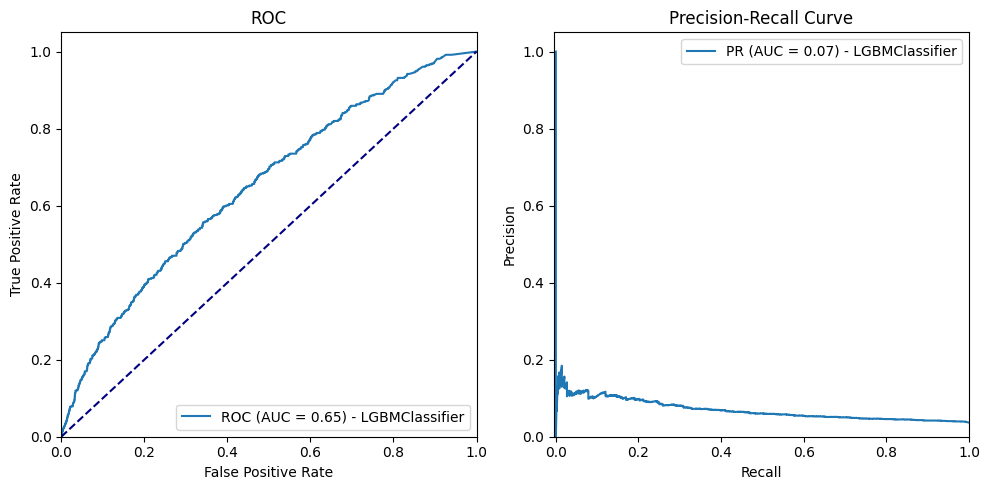

INFO - Precision in the first decile: 0.09
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    2.463207
1    1.345449
2    1.139322
3    1.034961
4    0.891420
5    0.744606
6    0.932881
7    0.599822
8    0.560581
9    0.288912
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
38                   MIN_DAYS_PERM_CURR           69
112                       NUM_PERM_CURR           63
115                        NUM_PREV_OBJ           58
0                          pago_final_0           44
164  service_fix_pending_install_3month           44
150            dif_periodica_prev_month           43
74     NUM_DAYS_LINE_TYP

In [35]:
query = """
WITH selectable_customer AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
    GROUP BY customer_id
), 

customer_selected AS (
    SELECT customer_id AS selected_customer
    FROM   selectable_customer
    WHERE  MOD(ABS(HASH(customer_id)), 10) = 0
)

SELECT *
FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
INNER JOIN customer_selected
ON customer_id = selected_customer
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""
# TO-DO: PARAMETRIZE THIS
save_curves_path = "src/models"
save_features_path = "src/features"
save_target_path = "src/target"

get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

In [3]:
get_initial_params()
save_features_path = "src/features"
save_curves_path = "src/models"


In [105]:
query = """
WITH selectable_customer AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
    GROUP BY customer_id
), 

customer_selected AS (
    SELECT customer_id AS selected_customer
    FROM   selectable_customer
    WHERE  MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 10) = 0
)

SELECT *
FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
INNER JOIN customer_selected
ON customer_id = selected_customer
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 224482
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO 

[LightGBM] [Info] Number of positive: 696, number of negative: 19273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66648
[LightGBM] [Info] Number of data points in the train set: 19969, number of used features: 343
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034854 -> initscore=-3.321111
[LightGBM] [Info] Start training from score -3.321111


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


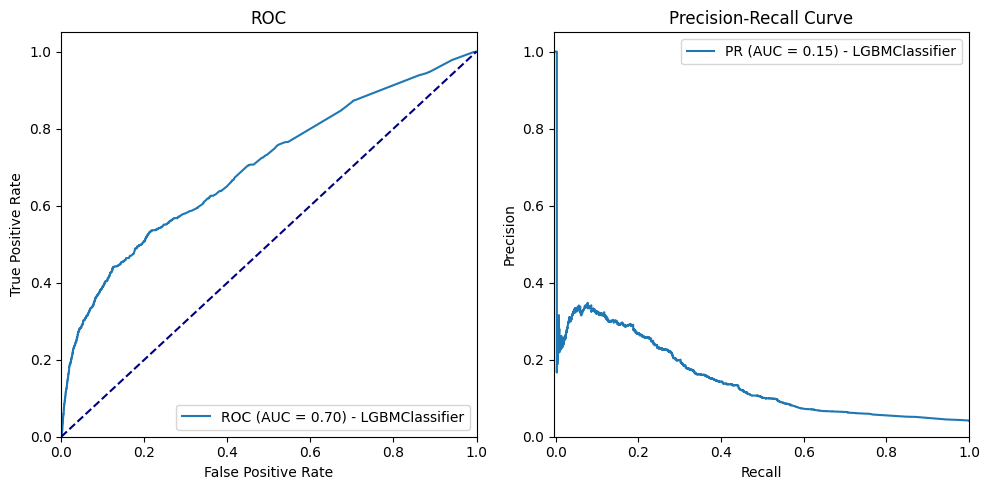

INFO - Precision in the first decile: 0.16
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    3.706230
1    1.256801
2    0.780691
3    0.670080
4    0.866585
5    0.674670
6    0.656280
7    0.676082
8    0.416807
9    0.478019
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                 Feature  Coefficient
76                        NUM_DISC_CURR           70
43                   MAX_DAYS_PERM_CURR           66
164  service_fix_pending_install_3month           60
182           aperiodica_0_avg_3_months           52
131       cust_days_since_last_mob_port           52
188            periodica_0_avg_6_months           30
141           dif_pago_f

In [106]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)
features, target, features_test, target_test = feature_computation(
    clean_data,
    train_from,
    train_to,
    logger,
    save_features_path=save_features_path,
    save_target_path=save_target_path,
)
model = modeling(features, target, lightgbm_params, logger)
model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path
)

In [4]:
query = """
WITH selectable_customer_2022 AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
    GROUP BY customer_id
), 
customer_selected_2022 AS (
    SELECT customer_id AS selected_customer_2022
    FROM selectable_customer_2022
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 10) = 0
),
selectable_customer_2023 AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
    GROUP BY customer_id
), 
customer_selected_2023 AS (
    SELECT customer_id AS selected_customer_2023
    FROM selectable_customer_2023
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 10) = 0
),
churned_users AS (
    SELECT selected_customer_2022 AS customer_id
    FROM customer_selected_2022
    WHERE selected_customer_2022 NOT IN (SELECT selected_customer_2023 FROM customer_selected_2023)
),
combined_data AS (
    SELECT 
        2022 AS year,
        cs2022.selected_customer_2022 AS customer_id,
        base2022.*,
        CASE 
            WHEN cs2022.selected_customer_2022 IN (SELECT customer_id FROM churned_users) 
            THEN TRUE 
            ELSE FALSE 
        END AS is_churned
    FROM customer_selected_2022 cs2022
    JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022` base2022
    ON cs2022.selected_customer_2022 = base2022.customer_id

    UNION ALL

    SELECT 
        2023 AS year,
        cs2023.selected_customer_2023 AS customer_id,
        base2023.*,
        FALSE AS is_churned
    FROM customer_selected_2023 cs2023
    JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1` base2023
    ON cs2023.selected_customer_2023 = base2023.customer_id
)

SELECT *
FROM combined_data
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 509539
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column NUM_FIX_PORT
INFO - Dropping column NUM_FIX_PORT_LAST_1_MONTH
INFO - Dropping column NUM_FIX_PORT_LAST_3_MONTHS
INFO - Dropping column NUM_FIX_PORT_LAST_6_MONTHS
INFO - Sh

In [5]:
raw_data

,year,customer_id,brand_ds,customer_id_1,YEAR_1,MONTH,EOP,IS_CUST_SEGM_RESI,IS_CUST_SEGM_SOHO,IS_CUST_SEGM_BUSI,...,MIN_NUM_DAYS_BETWEEN_FIX_PORT,NUM_PORT_OPER_DONO_PREM_TWO_YEAR_AGO,NUM_MOB_PORT_TRANS_CURR,MM_GROUP_MOB_PORT,NUM_MONTHS_SINCE_LAST_MOB_PORT_REQ,MAX_NUM_DAYS_BETWEEN_MOB_PORT_REQS,NUM_MONTHS_SINCE_LAST_MOB_PORT,MAX_NUM_MONTHS_BETWEEN_MOB_PORT_REQS,NUM_PORT_OPER_RECE_YOIGO_TWO_YEAR_AGO,is_churned
0,2023,2334203,EUSKALTEL,2334203,2023,08,202308,1,0,0,...,<NA>,0,0,3,43.355263,0,43.355263,0.000000,0,False
1,2023,2313724,EUSKALTEL,2313724,2023,03,202303,1,0,0,...,<NA>,0,0,0,2.861842,1337,46.842105,43.980263,0,False
2,2023,4082128,EUSKALTEL,4082128,2023,04,202304,1,0,0,...,<NA>,0,0,0,59.276316,<NA>,59.276316,NaN,0,False
3,2023,448263,EUSKALTEL,448263,2023,01,202301,1,0,0,...,<NA>,0,0,0,32.664474,<NA>,32.664474,NaN,0,False
4,2023,6102878,EUSKALTEL,6102878,2023,05,202305,1,0,0,...,<NA>,0,0,0,40.131579,0,40.131579,0.000000,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509534,2022,1750470,EUSKALTEL,1750470,2022,12,202212,1,0,0,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,False
509535,2022,74926,EUSKALTEL,74926,2022,02,202202,1,0,0,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,False
509536,2022,4167706,EUSKALTEL,4167706,2022,08,202208,1,0,0,...,<NA>,0,0,1,22.171053,0,NaN,0.000000,0,False
509537,2022,7288662,EUSKALTEL,7288662,2022,10,202210,1,0,0,...,<NA>,2,0,0,12.335526,0,12.335526,0.000000,0,False


In [6]:
raw_data['customer_id'].nunique()

29723

In [134]:
raw_data.columns.tolist()

['year',
 'customer_id',
 'brand_ds',
 'customer_id_1',
 'YEAR_1',
 'MONTH',
 'EOP',
 'IS_CUST_SEGM_RESI',
 'IS_CUST_SEGM_SOHO',
 'IS_CUST_SEGM_BUSI',
 'CHANNEL_LAST_MOBILE',
 'CHANNEL_FIRST_MOBILE',
 'CHANNEL_LAST_FIXE',
 'CHANNEL_FIRST_FIXE',
 'NUM_LINE_TYPE_FIXE_CURR',
 'NUM_LINES_POST_CURR',
 'NUM_LINE_TYPE_SUPD_CURR',
 'NUM_LINES_PREP_CURR',
 'NUM_LINE_TYPE_MAIN_POST_CURR',
 'NUM_LINE_TYPE_ADDI_POST_CURR',
 'NUM_LINE_TYPE_EXTR_POST_CURR',
 'NUM_LINE_TYPE_ADDI_CURR',
 'NUM_LINE_TYPE_EXTR_CURR',
 'NUM_LINE_TYPE_MAIN_CURR',
 'NUM_LINE_TYPE_SUPD_ACTI',
 'NUM_LINES_POST_ACTI',
 'NUM_LINES_PREP_ACTI',
 'NUM_LINE_TYPE_FIXE_POST_ACTI',
 'NUM_LINE_TYPE_MAIN_POST_ACTI',
 'NUM_LINE_TYPE_ADDI_POST_ACTI',
 'NUM_LINE_TYPE_EXTR_POST_ACTI',
 'NUM_LINE_TYPE_SUPD_DEAC',
 'NUM_LINE_TYPE_FIXE_POST_DEAC',
 'NUM_LINES_POST_DEAC',
 'NUM_LINES_PREP_DEAC',
 'NUM_LINE_TYPE_MAIN_POST_DEAC',
 'NUM_LINE_TYPE_EXTR_POST_DEAC',
 'NUM_LINE_TYPE_ADDI_POST_DEAC',
 'NUM_DAYS_LINE_TYPE_FIXE_POST_ACT',
 'NUM_DAYS_LINE

In [ ]:
WITH selectable_customer_2022 AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
    GROUP BY customer_id
), 
customer_selected_2022 AS (
    SELECT customer_id AS selected_customer_2022
    FROM selectable_customer_2022
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 100) = 0
),
selectable_customer_2023 AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
    GROUP BY customer_id
), 
customer_selected_2023 AS (
    SELECT customer_id AS selected_customer_2023
    FROM selectable_customer_2023
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 100) = 0
),
churned_users AS (
    SELECT selected_customer_2022 AS customer_id
    FROM customer_selected_2022
    WHERE selected_customer_2022 NOT IN (SELECT selected_customer_2023 FROM customer_selected_2023)
),
combined_data AS (
    SELECT 
        2022 AS year,
        cs2022.selected_customer_2022 AS customer_id,
        base2022.*,
        CASE 
            WHEN cs2022.selected_customer_2022 IN (SELECT customer_id FROM churned_users) 
            THEN TRUE 
            ELSE FALSE 
        END AS is_churned
    FROM customer_selected_2022 cs2022
    JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022` base2022
    ON cs2022.selected_customer_2022 = base2022.customer_id

    UNION ALL

    SELECT 
        2023 AS year,
        cs2023.selected_customer_2023 AS customer_id,
        base2023.*,
        FALSE AS is_churned
    FROM customer_selected_2023 cs2023
    JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1` base2023
    ON cs2023.selected_customer_2023 = base2023.customer_id
)

SELECT *
FROM combined_data
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL

In [5]:
print((train_from))

2023-01-01


In [21]:
query = """
WITH selectable_customer_2022 AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022`
    GROUP BY customer_id
), 
customer_selected_2022 AS (
    SELECT customer_id AS selected_customer_2022
    FROM selectable_customer_2022
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 100) = 0
),
selectable_customer_2023 AS (
    SELECT customer_id
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
    GROUP BY customer_id
), 
customer_selected_2023 AS (
    SELECT customer_id AS selected_customer_2023
    FROM selectable_customer_2023
    WHERE MOD(ABS(FARM_FINGERPRINT(CAST(customer_id AS STRING))), 100) = 0
),
churned_users AS (
    SELECT selected_customer_2022 AS customer_id
    FROM customer_selected_2022
    WHERE selected_customer_2022 NOT IN (SELECT selected_customer_2023 FROM customer_selected_2023)
),
combined_data AS (
    SELECT 
        2022 AS year,
        cs2022.selected_customer_2022 AS customer_id,
        base2022.*,
        CASE 
            WHEN cs2022.selected_customer_2022 IN (SELECT customer_id FROM churned_users) 
            THEN TRUE 
            ELSE FALSE 
        END AS is_churned
    FROM customer_selected_2022 cs2022
    JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2022` base2022
    ON cs2022.selected_customer_2022 = base2022.customer_id

    UNION ALL

    SELECT 
        2023 AS year,
        cs2023.selected_customer_2023 AS customer_id,
        base2023.*,
        FALSE AS is_churned
    FROM customer_selected_2023 cs2023
    JOIN `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1` base2023
    ON cs2023.selected_customer_2023 = base2023.customer_id
)

SELECT *
FROM combined_data
WHERE IS_CUST_SEGM_RESI > 0
AND IS_CUST_BILL_POST_CURR = TRUE
AND CUST_BUNDLE_CURR = 'FMC'
AND NUM_IMPAGOS = 0
AND pago_final_0 IS NOT NULL
"""

In [28]:
train_from
train_to

Timestamp('2023-07-01 00:00:00')

In [24]:
type(train_from)
train_from = pd.to_datetime(train_from)


str

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 52946
INFO - Starting cleaning data
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Dropping column Import_Rest_quota_disp
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO - Should fillna
INFO -

[LightGBM] [Info] Number of positive: 48, number of negative: 2054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62170
[LightGBM] [Info] Number of data points in the train set: 2102, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022835 -> initscore=-3.756343
[LightGBM] [Info] Start training from score -3.756343


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])
INFO - Generating plots


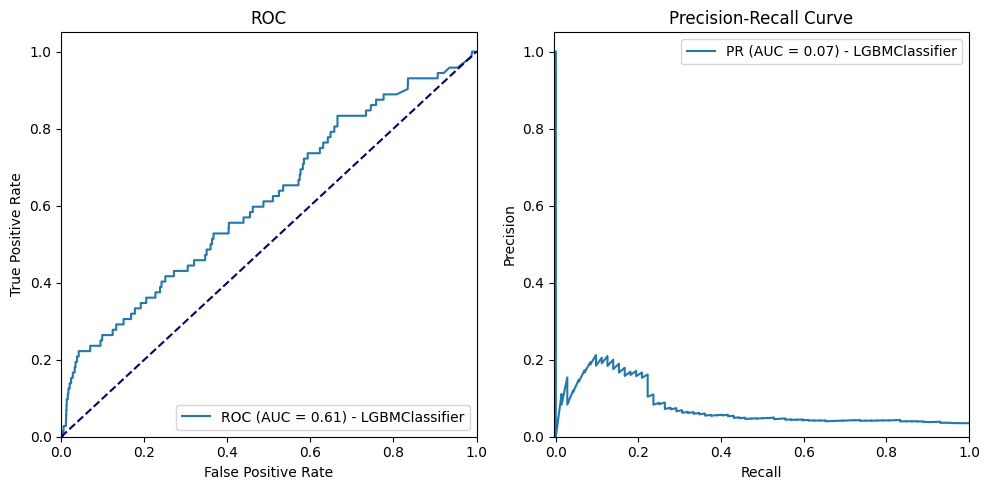

INFO - Precision in the first decile: 0.09
/home/dan1dr/zrive-ds-4q24-churn/src/evaluation.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
INFO - Uplift by decile:
INFO - decile
0    2.490291
1    0.973171
2    0.834146
3    0.973171
4    0.834146
5    1.251220
6    0.973171
7    0.556098
8    0.417073
9    0.691748
Name: y_true, dtype: float64
INFO - Completed evaluation!
INFO - Feature importance
INFO -                                       Feature  Coefficient
164        service_fix_pending_install_3month           67
182                 aperiodica_0_avg_3_months           58
345                NUM_CALL_WEEK_std_6_months           58
329        NUM_CALL_WEEKEND_CURR_std_3_months           46
43                         MAX_DAYS_PERM_CURR           42
274  PERC_SECS_TYPE_IN_NATR_CURR_std_3_mo

[LightGBM] [Info] Number of positive: 72, number of negative: 1980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62103
[LightGBM] [Info] Number of data points in the train set: 2052, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035088 -> initscore=-3.314186
[LightGBM] [Info] Start training from score -3.314186


INFO - Completed model training!
INFO - Started evaluation for Pipeline(steps=[('lightgbm',
                 LGBMClassifier(colsample_bytree=0.64, learning_rate=0.005,
                                num_leaves=12, random_state=500, reg_alpha=0,
                                reg_lambda=1, subsample=0.7))])


ValueError: Input data must be 2 dimensional and non empty.

In [31]:
get_initial_params()
raw_data = data_gathering(query, logger)
clean_data = data_cleaning(raw_data, logger)

all_data = {}
last_train_period = pd.to_datetime(end_date) - pd.DateOffset(months=3)
train_from = pd.to_datetime(train_from)
train_to = pd.to_datetime(train_to)


while train_to <= last_train_period:

    logger.info(f"MODEL FOR {train_to}")

    str_train_from = train_from.strftime('%Y-%m-%d')
    str_train_to = train_to.strftime('%Y-%m-%d')

    features, target, features_test, target_test = feature_computation(
        clean_data, str_train_from, str_train_to, logger
    )
    logger.info(f"{type(train_from)}")
    model = modeling(features, target, lightgbm_params, logger)
    model_metrics, precision_decile, uplift_by_decile, feature_importance = evaluation(
    model, features_test, target_test, logger, save_curves_path)

    all_data[train_to.strftime('%Y-%m')] = {
        'features': features,
        'target': target,
        'features_test': features_test,
        'target_test': target_test,
        'model': model,
        'metrics': model_metrics,
        'precision_decile': precision_decile,
        'uplift_by_decile': uplift_by_decile,
        'feature_importance': feature_importance
    }
    #to-do pass directly datetimes into feature_computation and not use this here 

    train_from += pd.DateOffset(months=1)
    train_to += pd.DateOffset(months=1)


In [44]:
query = """
WITH selectable_customer AS (
        SELECT customer_id
        FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
        GROUP BY customer_id
    ), 

    customer_selected AS (
        SELECT customer_id AS selected_customer
        FROM   selectable_customer
        WHERE  RAND() < 0.1
    )

    SELECT *
    FROM `mm-bi-catedras-upm.ESTIMACION_CHURN.multibrand_monthly_customer_base_mp2023_1`
    INNER JOIN customer_selected
    ON customer_id = selected_customer
    WHERE IS_CUST_SEGM_RESI > 0
    AND IS_CUST_BILL_POST_CURR = TRUE
    AND CUST_BUNDLE_CURR = 'FMC'
    AND NUM_IMPAGOS = 0
    AND pago_final_0 IS NOT NULL
"""

In [45]:
raw_data = data_gathering(query, logger)
raw_data[(raw_data['year'] == 2023) & (raw_data['MONTH'] == '08')]

INFO - Started querying data
INFO - Data succesfully retrieved! Length: 227455


KeyError: 'year'

In [56]:
raw_data[(raw_data['YEAR'] == '2023') & (raw_data['MONTH'] == '09')]

,brand_ds,customer_id,YEAR,MONTH,EOP,IS_CUST_SEGM_RESI,IS_CUST_SEGM_SOHO,IS_CUST_SEGM_BUSI,CHANNEL_LAST_MOBILE,CHANNEL_FIRST_MOBILE,...,MIN_NUM_DAYS_BETWEEN_FIX_PORT,NUM_PORT_OPER_DONO_PREM_TWO_YEAR_AGO,NUM_MOB_PORT_TRANS_CURR,MM_GROUP_MOB_PORT,NUM_MONTHS_SINCE_LAST_MOB_PORT_REQ,MAX_NUM_DAYS_BETWEEN_MOB_PORT_REQS,NUM_MONTHS_SINCE_LAST_MOB_PORT,MAX_NUM_MONTHS_BETWEEN_MOB_PORT_REQS,NUM_PORT_OPER_RECE_YOIGO_TWO_YEAR_AGO,selected_customer
13,EUSKALTEL,473594,2023,09,202309,1,0,0,PLAT. FIDELIZACION/RETENCION,PLAT. FIDELIZACION/RETENCION,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,473594
19,EUSKALTEL,195890,2023,09,202309,1,0,0,OUTBOUND,OUTBOUND,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,195890
21,EUSKALTEL,193974,2023,09,202309,1,0,0,None,EXCLUSIVO,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,193974
55,EUSKALTEL,134507,2023,09,202309,1,0,0,PLAT. FIDELIZACION/RETENCION,PLAT. FIDELIZACION/RETENCION,...,<NA>,<NA>,<NA>,1,NaN,<NA>,NaN,NaN,<NA>,134507
58,EUSKALTEL,764896,2023,09,202309,1,0,0,PLAT. FIDELIZACION/RETENCION,PLAT. FIDELIZACION/RETENCION,...,<NA>,<NA>,<NA>,0,NaN,<NA>,NaN,NaN,<NA>,764896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227422,EUSKALTEL,7523009,2023,09,202309,1,0,0,WEB ASISTIDA INBOUND,WEB ASISTIDA INBOUND,...,<NA>,4,0,4,12.368421,0,12.368421,0.0,0,7523009
227433,EUSKALTEL,7662822,2023,09,202309,1,0,0,D2D RESTO,D2D RESTO,...,<NA>,3,0,0,4.342105,0,4.342105,0.0,0,7662822
227437,EUSKALTEL,2058825,2023,09,202309,1,0,0,D2D RESTO,D2D RESTO,...,<NA>,2,0,8,10.328947,0,10.328947,0.0,0,2058825
227447,EUSKALTEL,7385494,2023,09,202309,1,0,0,PLAT. FIDELIZACION/RETENCION,PLAT. FIDELIZACION/RETENCION,...,<NA>,4,0,1,12.861842,0,12.861842,0.0,0,7385494


In [11]:
INFO - Train computation from 2023-02-01 00:00:00 to 2023-07-01 00:00:00. Target for 2023-09-01 00:00:00
INFO - Test computation from 2023-03-01 00:00:00 to 2023-08-01 00:00:00. Target for 2023-10-01 00:00:00

,pago_final_0,consumo_0,aperiodica_0,periodica_0,discount_0,ajuste_0,NUM_GB_OWNN_CURR,NUM_GB_2G_CURR,NUM_GB_3G_CURR,NUM_GB_4G_CURR,...,NUM_CALL_WEEK_prev_month,NUM_CALL_WEEK_avg_3_months,NUM_CALL_WEEK_avg_6_months,NUM_CALL_WEEK_std_3_months,NUM_CALL_WEEK_std_6_months,NUM_CALL_WEEKEND_prev_month,NUM_CALL_WEEKEND_avg_3_months,NUM_CALL_WEEKEND_avg_6_months,NUM_CALL_WEEKEND_std_3_months,NUM_CALL_WEEKEND_std_6_months


In [37]:
train_from = "2023-01-01"
train_to = "2023-06-01"

features, target, features_test, target_test = feature_computation(
        clean_data, str_train_from, str_train_to, logger
    )

INFO - Starting feature computation
INFO - Train computation from 2023-02-01 00:00:00 to 2023-07-01 00:00:00. Target for 2023-09-01 00:00:00
INFO - Test computation from 2023-03-01 00:00:00 to 2023-08-01 00:00:00. Target for 2023-10-01 00:00:00
INFO - Removing 485 previous churned users from train set
INFO - Removing 483 previous churned users from test set
INFO - Unique customers in train: 2258
INFO - Unique customers in test: 2269
INFO - Starting features and target computation
INFO - Initial number of features passed: 176
INFO - Starting computation
/home/dan1dr/zrive-ds-4q24-churn/src/feature_computation.py:194: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/home/dan1dr/zrive-ds-4q24-churn/src/feature_computation.py:196: PerformanceWarning: DataFrame is h

In [35]:
features

,pago_final_0,consumo_0,aperiodica_0,periodica_0,discount_0,ajuste_0,NUM_GB_OWNN_CURR,NUM_GB_2G_CURR,NUM_GB_3G_CURR,NUM_GB_4G_CURR,...,NUM_CALL_WEEK_prev_month,NUM_CALL_WEEK_avg_3_months,NUM_CALL_WEEK_avg_6_months,NUM_CALL_WEEK_std_3_months,NUM_CALL_WEEK_std_6_months,NUM_CALL_WEEKEND_prev_month,NUM_CALL_WEEKEND_avg_3_months,NUM_CALL_WEEKEND_avg_6_months,NUM_CALL_WEEKEND_std_3_months,NUM_CALL_WEEKEND_std_6_months
0,102.6894,236.9552,0.0,122.3365,-256.6023,0.0,2.687163,0.000069,0.091821,7.779998,...,90,108.000000,124.166667,40.149720,57.398316,6,12.333333,20.500000,7.094599,12.045746
1,58.7629,310.5497,0.0,103.7674,-355.5542,0.0,0.302367,0.000159,0.008130,0.490034,...,170,175.333333,178.666667,12.858201,23.888630,56,49.000000,44.000000,12.124356,9.979980
2,57.2538,134.2320,0.0,111.2983,-188.2765,0.0,0.088088,0.000004,0.003369,0.267110,...,97,88.000000,82.166667,9.000000,13.991664,30,32.333333,31.000000,15.631165,10.276186
3,90.0900,42.8429,0.0,139.0249,-91.7778,0.0,0.176229,0.000069,0.013294,3.512921,...,123,121.666667,114.166667,21.031722,36.809872,26,27.000000,25.500000,2.645751,4.460942
4,49.0000,46.6165,0.0,84.5941,-82.2106,0.0,0.164062,0.000364,0.703927,0.000000,...,57,68.000000,59.000000,15.716234,14.845875,8,13.666667,13.500000,6.027714,4.593474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119,64.9296,48.8222,0.0,103.2812,-87.1738,0.0,1.828739,0.000059,0.029388,1.461574,...,35,46.666667,48.833333,11.060440,8.035339,9,17.333333,20.333333,7.234178,7.312090
2120,77.7629,301.5435,0.0,118.6352,-342.4158,0.0,0.528609,0.000024,0.016606,3.439454,...,346,289.333333,317.000000,53.780418,49.372057,81,79.666667,76.500000,4.163332,10.445095
2121,84.1724,963.2172,0.0,167.4686,-1046.5134,0.0,29.234258,0.000598,7.625259,84.148537,...,988,780.333333,737.000000,193.908054,139.173273,227,228.333333,228.833333,2.309401,5.528713
2122,37.9195,19.3965,0.0,71.2782,-52.7552,0.0,0.000168,0.000025,0.000847,0.085075,...,67,66.666667,66.000000,5.507571,5.138093,8,11.333333,11.166667,4.163332,4.665476


In [36]:
features_test

,pago_final_0,consumo_0,aperiodica_0,periodica_0,discount_0,ajuste_0,NUM_GB_OWNN_CURR,NUM_GB_2G_CURR,NUM_GB_3G_CURR,NUM_GB_4G_CURR,...,NUM_CALL_WEEK_prev_month,NUM_CALL_WEEK_avg_3_months,NUM_CALL_WEEK_avg_6_months,NUM_CALL_WEEK_std_3_months,NUM_CALL_WEEK_std_6_months,NUM_CALL_WEEKEND_prev_month,NUM_CALL_WEEKEND_avg_3_months,NUM_CALL_WEEKEND_avg_6_months,NUM_CALL_WEEKEND_std_3_months,NUM_CALL_WEEKEND_std_6_months
